In [7]:
%pylab inline
import IPython.core.debugger as ipdb
import argparse as argp
import nibabel as nib
import numpy as np
import os 
from nilearn import plotting

def dive(root):
    print(root)
    for f in os.listdir(root):
        path = rf'{root}/{f}'
        print(path)
        if f.endswith('.mgz'):
            nii_path = convert(root, f)
            clip_space(nii_path)
        elif os.path.isdir(path):
            dive(path)
            
def convert(root, f):
    os.system(rf'mri_convert {root}/{f} {root}/image.nii')
    return rf'mri_convert {root}/{f} {root}/image.nii'

# remove the surrounding zero-intensity space from the brain
def clip_boundary(path):
    img = nib.load(path)
    
    slice_0 = epi_img_data[26, :, :]
    axes[0].imshow(slice.T, cmap="gray", origin="lower")
    

Populating the interactive namespace from numpy and matplotlib


In [8]:
if __name__ == '__main__':
    parser = argp.ArgumentParser(description='convert .mgz files to .nii')
    parser.add_argument('path', type=str, nargs=1)
    args = parser.parse_args()
    dive(args.path[0])
    

usage: ipykernel_launcher.py [-h] path
ipykernel_launcher.py: error: unrecognized arguments: -f


SystemExit: 2

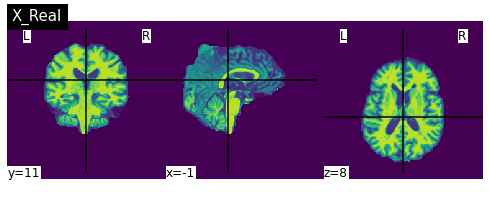

TypeError: Data given cannot be loaded because it is not compatible with nibabel format:
0.0

In [9]:

img = nib.load('../../ADNI/002_S_0295/FreeSurfer_Cross-Sectional_Processing_brainmask/2006-04-18_08_20_30.0/S13408/mri/image.nii')
# feat = nib.Nifti1Image(img, affine = np.eye(4))
plotting.plot_img(img, title="X_Real")
plotting.show()

# nib.Nifti1Image(img,affine = np.eye(4))
np_img = np.array(img.get_fdata())

x_len, y_len, z_len = len(np_img), len(np_img[0]), len(np_img[1])
zero_mask = np.zeros((y_len, z_len))
# clean X 
del_inds = []
for i in range(x_len):
    #check if the plane is all zeros 
    if np.sum(np_img[i] != zero_mask) == 0:
        del_inds.append(i)
# clean Y
del_inds = []
for i in range(y_len):
    #check if the plane is all zeros 
    if np.sum(np_img[i] != zero_mask) == 0:
        del_inds.append(i)
np_img = np.delete(np_img, del_inds, 0)
# ipdb.set_trace()
feat = nib.Nifti1Image(np_img, np.eye(4))
plotting.plot_img(np_img,title="X_Real")
plotting.show()

In [ ]:
np.eye(4)